<a href="https://colab.research.google.com/github/h2mauricio/Map-PV-Plants-California/blob/main/Mapping_PV_plants_inventory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geographic Data and Descriptive Stats of PV Plants Inventory


---
Goal(s):
- Create an interactive visualization for geographical data of PV installed plants by technology data requested and downloaded from [EIA API v2](https://www.eia.gov/opendata/browser/electricity/).


**References:**
- [Python Data Science Handbook](https://https://github.com/jakevdp/PythonDataScienceHandbook)
- [The Data Frog](https://thedatafrog.com/en/articles/show-data-google-map-python/)


In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from pathlib import Path
#Bokeh libraries
from bokeh.io import output_notebook, show
from bokeh.plotting import gmap
from bokeh.transform import linear_cmap
from bokeh.palettes import Plasma256 as palette
from bokeh.models import ColumnDataSource, ColorBar, HoverTool, GMapOptions

#Connect to google drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get Google Map API Key

The Google Map API key is required to be able to create a Google Map from an application or a website.

To obtain your API key, please follow the instructions from Google: [Get Google API Key](https://developers.google.com/maps/documentation/embed/get-api-key)


In this poject we we will use the [Maps JavaScript API](https://developers.google.com/maps/documentation/javascript)

Please note that the Google Map API is **NOT FREE**. But Google offers $200 USD of free credit per month, which is equivalent to almost 30,000 maploads per month (https://mapsplatform.google.com/pricing/). More than enough for a basic application like this.


## Loading Dataset with Pandas

Start by defining local path and input and output paths

In [7]:
#Create paths
local_path = Path('/content/drive/MyDrive/Weekly Viz/US Power Grid/')

data_path = local_path.joinpath('Data/CA')
pv_inv_path = data_path.joinpath('inventory')
fig_path = data_path.joinpath('figs')

In [8]:
api_key_file= data_path.parent.joinpath('gmap_apikey.txt')

#read file with api_key
with open(api_key_file, 'r') as f:
  api_key = f.read()

Read file with information of PV plants

In [9]:
year =2019
filename = 'pv_plants_{iyear}-12_{iyear}-12.csv'.format(iyear=year)
df_pv_inventory = pd.read_csv(pv_inv_path.joinpath(filename))
df_pv_inventory.head()

,period,stateid,stateName,sector,sectorName,entityid,entityName,plantid,plantName,generatorid,...,planned-derate-year-month,planned-retirement-year-month,planned-uprate-summer-cap-mw,planned-uprate-year-month,unit,nameplate-capacity-mw-units,net-summer-capacity-mw-units,net-winter-capacity-mw-units,planned-derate-summer-cap-mw-units,planned-uprate-summer-cap-mw-units
0,2019-12,CA,California,ipp-non-chp,IPP Non-CHP,61872,Gavilan District College Solar Project,61993,Gavilan District College Solar Project,GDCBA,...,NaN,NaN,NaN,NaN,NaN,MW,MW,MW,MW,MW
1,2019-12,CA,California,ipp-non-chp,IPP Non-CHP,61872,Gavilan District College Solar Project,61993,Gavilan District College Solar Project,GDCPV,...,NaN,NaN,NaN,NaN,NaN,MW,MW,MW,MW,MW
2,2019-12,CA,California,ipp-non-chp,IPP Non-CHP,15908,"GenOn California South, LP",8076,Ellwood,01,...,NaN,2023-12,NaN,NaN,NaN,MW,MW,MW,MW,MW
3,2019-12,CA,California,ipp-non-chp,IPP Non-CHP,15908,"GenOn California South, LP",350,Ormond Beach,1,...,NaN,2023-12,NaN,NaN,NaN,MW,MW,MW,MW,MW
4,2019-12,CA,California,ipp-non-chp,IPP Non-CHP,15908,"GenOn California South, LP",350,Ormond Beach,2,...,NaN,2023-12,NaN,NaN,NaN,MW,MW,MW,MW,MW


**Setup Bokeh environment**

In [10]:
#output will be inline in the associated notebook output cell
output_notebook()
#define height and width of visualizations
bokeh_width, bokeh_height = 500,400

## Simple Dynamic Google Map (one location)

We need to choose a coordinate for the center of the map. I decided to select Mexico City. You need the latitude and longitude.

In [11]:
lat, lon = 19.4326, -99.1332

**Plotting point in terrain map**

Then, we import the bokeh tools needed to show a simple dynamic map, and we write a small function to show the map:

In [ ]:
def map_single_point(lat, lng, zoom=10, map_type='roadmap'):
    gmap_options = GMapOptions(lat=lat, lng=lng,
                               map_type=map_type, zoom=zoom)
    p = gmap(api_key, gmap_options, title='Single location',
             width=bokeh_width, height=bokeh_height)
    # beware, longitude is on the x axis ;-)
    center = p.circle([lng], [lat], size=10, alpha=0.5, color='red')
    return p

p_single = map_single_point(lat, lon, map_type='terrain')
show(p_single)

**Plotting point in satellite map**

In [ ]:
show(map_single_point(lat, lon, map_type='satellite'))

## Map with Data Overlay

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def read_agg_pv_inventory(year=2018, list_pv_attr = ['stateid', 'plantid', 'plantName', 'balancing_authority_code', 'latitude', 'longitude', 'nameplate-capacity-mw']):
  filename = 'pv_plants_{iyear}-12_{iyear}-12.csv'.format(iyear=year)
  df_pv_inventory = pd.read_csv(pv_inv_path.joinpath(filename))
  df_pv_inventory = df_pv_inventory.loc[:,list_pv_attr].copy()

  df_pv_inventory = df_pv_inventory.groupby(by=['plantid', 'plantName', 'balancing_authority_code', 'latitude', 'longitude'], dropna=False).sum()
  df_pv_inventory.reset_index(inplace=True)
  df_pv_inventory.index = df_pv_inventory.plantid
  df_pv_inventory.insert(1, 'year', year)
  df_pv_inventory.drop(columns='plantid', inplace=True)
  #df_pv_inventory['year'] = year
  return df_pv_inventory

df_pv_inv = read_agg_pv_inventory(year=2019)
df_pv_inv.head(n=5)

,year,plantName,balancing_authority_code,latitude,longitude,stateid,nameplate-capacity-mw
plantid,,,,,,,
34,2019,Rollins,CISO,39.134259,-120.953341,CA,12.1
72,2019,Venice Hydro,CISO,34.011350,-118.416800,CA,10.1
104,2019,J S Eastwood,CISO,37.147926,-119.256700,CA,199.8
180,2019,Volta 2,CISO,40.451930,-121.862150,CA,1.0
214,2019,Alta Powerhouse,CISO,39.215979,-120.803550,CA,1.0


In [ ]:
df_pv_inv.describe()

,year,latitude,longitude,nameplate-capacity-mw
count,1250.0,1250.000000,1250.000000,1250.000000
mean,2019.0,35.969188,-119.304471,53.202960
std,0.0,2.088018,1.987794,153.034344
min,2019.0,32.543333,-124.210300,0.500000
25%,2019.0,34.131137,-121.168445,1.925000
50%,2019.0,35.434306,-119.058510,7.350000
75%,2019.0,37.644797,-117.830038,38.900000
max,2019.0,41.132500,-112.904028,2323.000000


In [ ]:
bokeh_width, bokeh_height = 600,500

#center
lat = 36
lon = -119

def map_pv_plants(df, lat, lng, zoom=6, map_type='roadmap'):
    gmap_options = GMapOptions(lat=lat, lng=lng,
                               map_type=map_type, zoom=zoom)

    df['capacity'] = df['nameplate-capacity-mw']
    hover = HoverTool(
        tooltips = [
            ('Plant name', '@plantName'),
            # the {0.} means that we don't want decimals
            # for 1 decimal, write {0.0}
            ('Nameplate capacity', '@capacity{0.} MW'),
        ]
    )
    p = gmap(api_key, gmap_options,
             title='PV Installed Plants in {}'.format(year),
             width=bokeh_width, height=bokeh_height,
             tools=[hover, 'reset', 'wheel_zoom', 'pan'])

    source = ColumnDataSource(df)
    # defining a color mapper, that will map values of pricem2
    # between 2000 and 8000 on the color palette
    mapper = linear_cmap('nameplate-capacity-mw', palette, 1., 100.)
    # we use the mapper for the color of the circles
    center = p.circle('longitude', 'latitude', size=5, alpha=0.6,
                      color=mapper, source=source)
    # and we add a color scale to see which values the colors
    # correspond to
    color_bar = ColorBar(title="Nameplate Capacity [MW]",
                         color_mapper=mapper['transform'],
                         location=(0,0))
    p.add_layout(color_bar, 'right')
    return p

#df_pv_inv['capacity'] = df_pv_inv['nameplate-capacity-mw']
p = map_pv_plants(df_pv_inv, lat=lat, lng=lon, map_type='roadmap', zoom= 6)
show(p)

## Create Maps for Different Years

In [ ]:
year =2018
df_pv_inv_2018 = read_agg_pv_inventory(year=year)
p_2018 = map_pv_plants(df_pv_inv_2018, lat=lat, lng=lon, map_type='terrain', zoom= 6)

year =2022
df_pv_inv_2022 = read_agg_pv_inventory(year=year)
p_2022 = map_pv_plants(df_pv_inv_2022, lat=lat, lng=lon, map_type='terrain', zoom= 6)

show(p_2018)
show(p_2022)

## Descriptive Statistics

First, we will join the data of all the PV plants inventory files. We read each CSV file and concatenate them to create a *big* dataframe that contains the info of the PV plants for all the years.

In [ ]:
df_pv_inv =  pd.DataFrame()
#year =2018
for year in range(2018, 2023):
  df_pv_inv_year = read_agg_pv_inventory(year=year)
  df_pv_inv = pd.concat([df_pv_inv, df_pv_inv_year], axis =0)
df_pv_inv.head()

,year,plantName,balancing_authority_code,latitude,longitude,stateid,nameplate-capacity-mw
plantid,,,,,,,
34,2018,Rollins,CISO,39.134259,-120.953341,CA,12.1
72,2018,Venice Hydro,CISO,34.011350,-118.416800,CA,10.1
104,2018,J S Eastwood,CISO,37.147926,-119.256700,CA,199.8
180,2018,Volta 2,CISO,40.451930,-121.862150,CA,1.0
214,2018,Alta Powerhouse,CISO,39.215979,-120.803550,CA,1.0


Then, we calculate the descriptive statistics

In [ ]:
df_pv_inv_summary = pd.DataFrame()

for year in range(2018, 2023):
  #filter the information per year
  mask_year = (df_pv_inv.year == year)
  #get the descriptive statistics, this will create a pandas series
  # we change the name of the attribute to the year
  df_pv_inv_year = df_pv_inv[mask_year]['nameplate-capacity-mw'].describe()
  df_pv_inv_year.rename('{}'.format(year), inplace=True)
  #concatenating the descriptive statistics to the dataframe that has all the info
  df_pv_inv_summary = pd.concat([df_pv_inv_summary, df_pv_inv_year], axis = 1)
  #print(df_pv_inv[mask_year]['nameplate-capacity-mw'].describe())
  #print("-----------------------------")

#Show results. Rounding values to show them in a more compacted way
df_pv_inv_summary.round(3)

,2018,2019,2020,2021,2022
count,1194.000,1250.000,1279.000,1374.000,1437.000
mean,56.136,53.203,54.006,52.524,53.490
std,165.206,153.034,152.503,151.348,149.753
min,0.500,0.500,0.500,0.500,0.300
25%,2.000,1.925,1.900,1.800,1.800
50%,8.650,7.350,7.000,6.100,6.000
75%,40.875,38.900,41.450,40.000,42.000
max,2323.000,2323.000,2323.000,2323.000,2323.000


## Create Bar Plot with Total Capacity per Year

First, we need to compute total capacity per year. This is aggregating and adding the nameplate capacity of all the plants per year.

In [ ]:
df_pv_total_capacity = df_pv_inv[['year','nameplate-capacity-mw']].groupby(by=['year'], dropna=False).sum()
df_pv_total_capacity

,nameplate-capacity-mw
year,
2018,67026.7
2019,66503.7
2020,69073.1
2021,72167.6
2022,76865.2


Plotting the total capacity in a bar chart

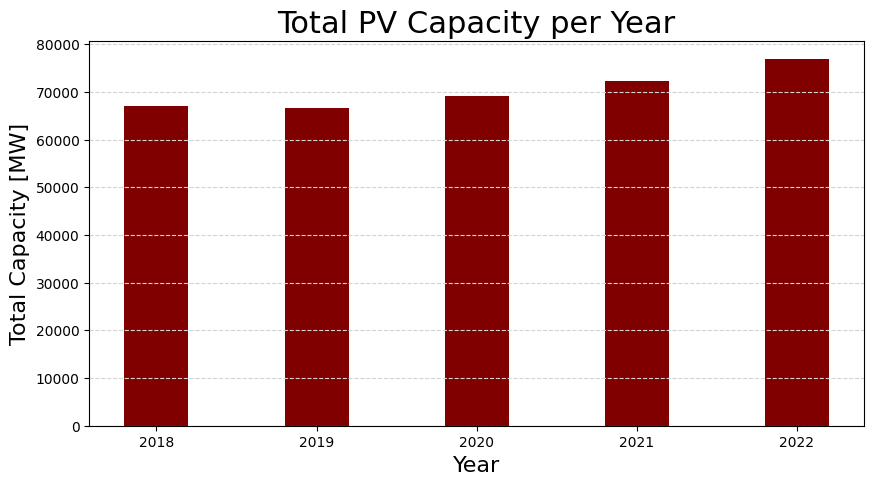

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize =(10, 5))

plt.grid(axis='y', color= 'lightgrey', linestyle='dashed')

# creating the bar plot
plt.bar(df_pv_total_capacity.index,
        df_pv_total_capacity['nameplate-capacity-mw'],
        color ='maroon',
        width = 0.4)

plt.xlabel("Year", size = 16)
plt.ylabel("Total Capacity [MW]", size =16)
plt.title("Total PV Capacity per Year", size = 22)
plt.show()

#save plot as PNG file
fig_filename = 'barplot_pv_total_capacity_per_year.png'
fig.savefig(fig_path.joinpath(fig_filename),
            dpi = 200,
            bbox_inches = 'tight')

## Extra: Plotting Maps using Basemap

In [ ]:
#!pip install basemap

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pathlib import Path

In [ ]:
plt.figure(figsize=(8, 8))
m = Basemap(projection='ortho', resolution=None, lat_0=50, lon_0=-100)
m.bluemarble(scale=0.5);

In [ ]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution=None,
            width=8E6, height=8E6,
            lat_0=45, lon_0=-100,)
m.etopo(scale=0.5, alpha=0.5)

# Map (long, lat) to (x, y) for plotting
x, y = m(-122.4194, 37.7749)
plt.plot(x, y, 'ok', markersize=5)
plt.text(x, y, ' San Francisco', fontsize=12);

## California Cities

In [ ]:
import pandas as pd
cities = pd.read_csv(in_path.joinpath('california_cities.csv'))

# Extract the data we're interested in
lat = cities['latd'].values
lon = cities['longd'].values
population = cities['population_total'].values
area = cities['area_total_km2'].values

In [ ]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
#m = Basemap(projection='lcc', resolution='h',
#            lat_0=37.5, lon_0=-119,
#            width=1E6, height=1.2E6)

m = Basemap(projection='lcc', resolution='c',
            width=1E6, height=1.2E6,
            lat_0=37.5, lon_0=-119,)
m.etopo(scale=0.5, alpha=0.5)

m.shadedrelief()
m.drawcounties(color='b')
#m.drawcoastlines(color='gray')
#m.drawcountries(color='gray')
#m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=np.log10(population), s=area,
          cmap='Reds', alpha=0.5)

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm population})$')
plt.clim(3, 7)

# make legend with dummy points
for a in [100, 300, 500]:
    plt.scatter([], [], c='k', alpha=0.5, s=a,
                label=str(a) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');